# Project 2

It is October 2018. The squirrels in Central Park are running into a problem and we need your help.

For this project you must go through most steps in the checklist. You must write responses for all items however sometimes the item will simply be "does not apply". Some of the parts are a bit more nebulous and you simply show that you have done things in general (and the order doesn't really matter). Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Do not do the final part (launching the product) and your presentation will be done as information written in this document in a dedicated section, no slides or anything like that. It should however include the best summary plots/graphics/data points.

You are intentionally given very little information thus far. You must communicate with your client (me) for additional information as necessary. But also make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

You must submit all data files and a pickled preprocessor and final model along with this notebook.

### **Objective**

- There is an outbreak affecting squirrels in Central Park, and we need to try and identify and manage the diseased ones using data from the Squirrel Census, which includes approximately 3,000 squirrel sightings. We aim to determine which squirrels tested positive for the disease and analyze these sightings to uncover patterns or indicators that could help predict the presence of the disease. It's important to note that squirrel behavior varies by type, and certain diseases may be influenced by fluctuating weather conditions. By understanding these factors, we hope to develop a more effective strategy for managing the outbreak.


### *Imports Goes Here*

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer


# **Get the Data**
1. **List the data you need and how much you need:**
    - Need weather data because squirrel sightings might vary per type of weather.
    - daily NYC Weather data
2. **Find and document where you can get that data:**
    - Publicly available from: [Kaggle](https://www.kaggle.com/datasets/aadimator/nyc-weather-2016-to-2022)
3. **Get access authorizations**: None needed, publicly available.


### *Loading Datasets...*

- To prepare for merging data later, we start by loading the necessary datasets



In [2]:
squirrel_data = pd.read_csv("2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20241105.csv")
weather_data = pd.read_csv("NYC_Weather_2016_2022.csv")

### *Functions for Cleaning and Merging Data*
- In new dataset. (i.e. samples with dates that don't have a squirrel sighting on the same day.)
- The `retrieve_weather_days` function filters the weather data to include only dates when squirrel sightings occurred. The `merge_datasets` function then combines the squirrel and weather datasets based on these matching dates.


#### TODO: Currently drop samples and only keep the weather measurements at noon, potentially could make it so we take a average of the measurements in teh second or first half of the day relative to the `Shift` feature designating if it should be `AM` or `PM`.

In [3]:
import pandas as pd

def retrieve_weather_days(weather_dataset, squirrel_dataset):
    squirrel_dataset["Date"] = pd.to_datetime(squirrel_dataset["Date"], format='%m%d%Y')
    sighting_dates = squirrel_dataset["Date"].dt.date.unique().tolist()
    weather_dataset["time"] = pd.to_datetime(weather_dataset["time"])
    weather_dataset["Date"] = weather_dataset["time"].dt.date
    weather_dataset = weather_dataset[weather_dataset["Date"].isin(sighting_dates)]
    
    return weather_dataset

# TODO: Fix merging
def merge_datasets(weather_dataset, squirrel_dataset):
    squirrel_dataset["Date"] = pd.to_datetime(squirrel_dataset["Date"], format='%m%d%Y')
    weather_dataset["time"] = pd.to_datetime(weather_dataset["time"])
    weather_dataset = weather_dataset[weather_dataset["time"].dt.hour == 12]
    weather_dataset["Date"] = pd.to_datetime(weather_dataset["time"].dt.date)
    weather_dataset = weather_dataset.drop(columns=["time"])
    squirrel_dataset["Date"] = pd.to_datetime(squirrel_dataset["Date"])
    merged_dataset = squirrel_dataset.merge(weather_dataset, on="Date", how="inner")
    
    return merged_dataset

weather_data = retrieve_weather_days(weather_data, squirrel_data)
data = merge_datasets(weather_data, squirrel_data)

/var/folders/gq/f3j82_650073w0x8z5ytw87w0000gp/T/ipykernel_99357/1089361996.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_dataset["Date"] = pd.to_datetime(weather_dataset["time"].dt.date)


In [4]:
# Load the diseased squirrels data
diseased_squirrels = pd.read_csv("diseased_squirrels.csv")

# Add a column to indicate if the squirrel is diseased
data['Diseased'] = data['Unique Squirrel ID'].isin(diseased_squirrels['Unique Squirrel ID'])

# Display the first few rows to verify
data.head()



,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°),Diseased
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,2018-10-14,3,NaN,NaN,NaN,...,9.5,0.0,0.0,56.0,0.0,58.0,71.0,5.1,309.0,False
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,2018-10-19,4,NaN,NaN,NaN,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,11.9,241.0,False
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,2018-10-14,8,NaN,Gray,NaN,...,9.5,0.0,0.0,56.0,0.0,58.0,71.0,5.1,309.0,False
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,2018-10-17,14,Adult,Gray,NaN,...,8.0,0.0,0.0,3.0,0.0,0.0,11.0,13.6,238.0,False
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,2018-10-17,5,Adult,Gray,Cinnamon,...,8.0,0.0,0.0,3.0,0.0,0.0,11.0,13.6,238.0,False


In [5]:
data.head()

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°),Diseased
0,-73.956134,40.794082,37F-PM-1014-03,37F,PM,2018-10-14,3,NaN,NaN,NaN,...,9.5,0.0,0.0,56.0,0.0,58.0,71.0,5.1,309.0,False
1,-73.968857,40.783783,21B-AM-1019-04,21B,AM,2018-10-19,4,NaN,NaN,NaN,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,11.9,241.0,False
2,-73.974281,40.775534,11B-PM-1014-08,11B,PM,2018-10-14,8,NaN,Gray,NaN,...,9.5,0.0,0.0,56.0,0.0,58.0,71.0,5.1,309.0,False
3,-73.959641,40.790313,32E-PM-1017-14,32E,PM,2018-10-17,14,Adult,Gray,NaN,...,8.0,0.0,0.0,3.0,0.0,0.0,11.0,13.6,238.0,False
4,-73.970268,40.776213,13E-AM-1017-05,13E,AM,2018-10-17,5,Adult,Gray,Cinnamon,...,8.0,0.0,0.0,3.0,0.0,0.0,11.0,13.6,238.0,False


### *Data Information*

- The dataset contains 3,023 entries and 41 columns with a mix of numerical, categorical, boolean, and date data types. Some columns have missing values, particularly `Color Notes`, `Other Activities`, `Other Interactions`, and `Highlight Fur Color`. While many columns are fully populated, those related to fur color details and specific locations show substantial gaps, indicating potential areas for data cleaning.

### *Missing Values*

  - **Age** (121 missing values)
  - **Primary Fur Color** (55 missing values)
  - **Highlight Fur Color** (1,086 missing values)
  - **Location** (64 missing values)
  - **Above Ground Sighter Measurement** (114 missing values)
  - **Specific Location** (2,547 missing values)
  - **Color Notes** (2,841 missing values)
  - **Other Activities** (2,586 missing values)
  - **Other Interactions** (2,783 missing values)



In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3023 entries, 0 to 3022
Data columns (total 41 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   X                                           3023 non-null   float64       
 1   Y                                           3023 non-null   float64       
 2   Unique Squirrel ID                          3023 non-null   object        
 3   Hectare                                     3023 non-null   object        
 4   Shift                                       3023 non-null   object        
 5   Date                                        3023 non-null   datetime64[ns]
 6   Hectare Squirrel Number                     3023 non-null   int64         
 7   Age                                         2902 non-null   object        
 8   Primary Fur Color                           2968 non-null   object        
 9   Highligh

In [7]:
data.describe()

,X,Y,Date,Hectare Squirrel Number,temperature_2m (°C),precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°)
count,3023.000000,3023.000000,3023,3023.000000,3023.000000,3023.000000,3023.000000,3023.000000,3023.000000,3023.000000,3023.000000,3023.000000,3023.000000
mean,-73.967184,40.780853,2018-10-11 17:55:35.626860800,4.123718,13.927291,0.143566,0.143566,70.770758,56.079061,43.011578,36.875289,9.806682,229.250083
min,-73.981159,40.764911,2018-10-06 00:00:00,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.400000,73.000000
25%,-73.973102,40.771676,2018-10-08 00:00:00,2.000000,9.500000,0.000000,0.000000,33.000000,0.000000,0.000000,0.000000,7.100000,198.000000
50%,-73.968594,40.778166,2018-10-12 00:00:00,3.000000,15.200000,0.000000,0.000000,98.000000,60.000000,17.000000,11.000000,9.100000,238.000000
75%,-73.960189,40.791219,2018-10-14 00:00:00,6.000000,18.500000,0.000000,0.000000,100.000000,100.000000,81.000000,71.000000,11.900000,308.000000
max,-73.949722,40.800119,2018-10-20 00:00:00,23.000000,20.900000,1.000000,1.000000,100.000000,100.000000,100.000000,100.000000,23.500000,335.000000
std,0.007726,0.010285,NaN,3.096492,5.504647,0.350707,0.350707,39.530326,45.782100,38.252577,40.039887,5.279739,74.630599


### *Histograms*
- The data on squirrel sightings in Central Park during October 2018 reveals several patterns. Squirrel sightings are concentrated in specific areas, with X and Y coordinates showing bell-shaped distributions. Sightings occurred on various dates, with certain days experiencing higher counts. The number of squirrels per hectare is right-skewed, suggesting that most areas had few squirrels. Temperatures ranged from 10-20°C, typical for October in New York, while precipitation and rain were both right-skewed, indicating mostly dry conditions. Cloud cover data shows peaks at either clear or fully clouded skies, with few instances of partial cover. Wind speeds clustered between 5-15 km/h, typical for urban environments, and wind direction appeared to be uniformly distributed across various directions.

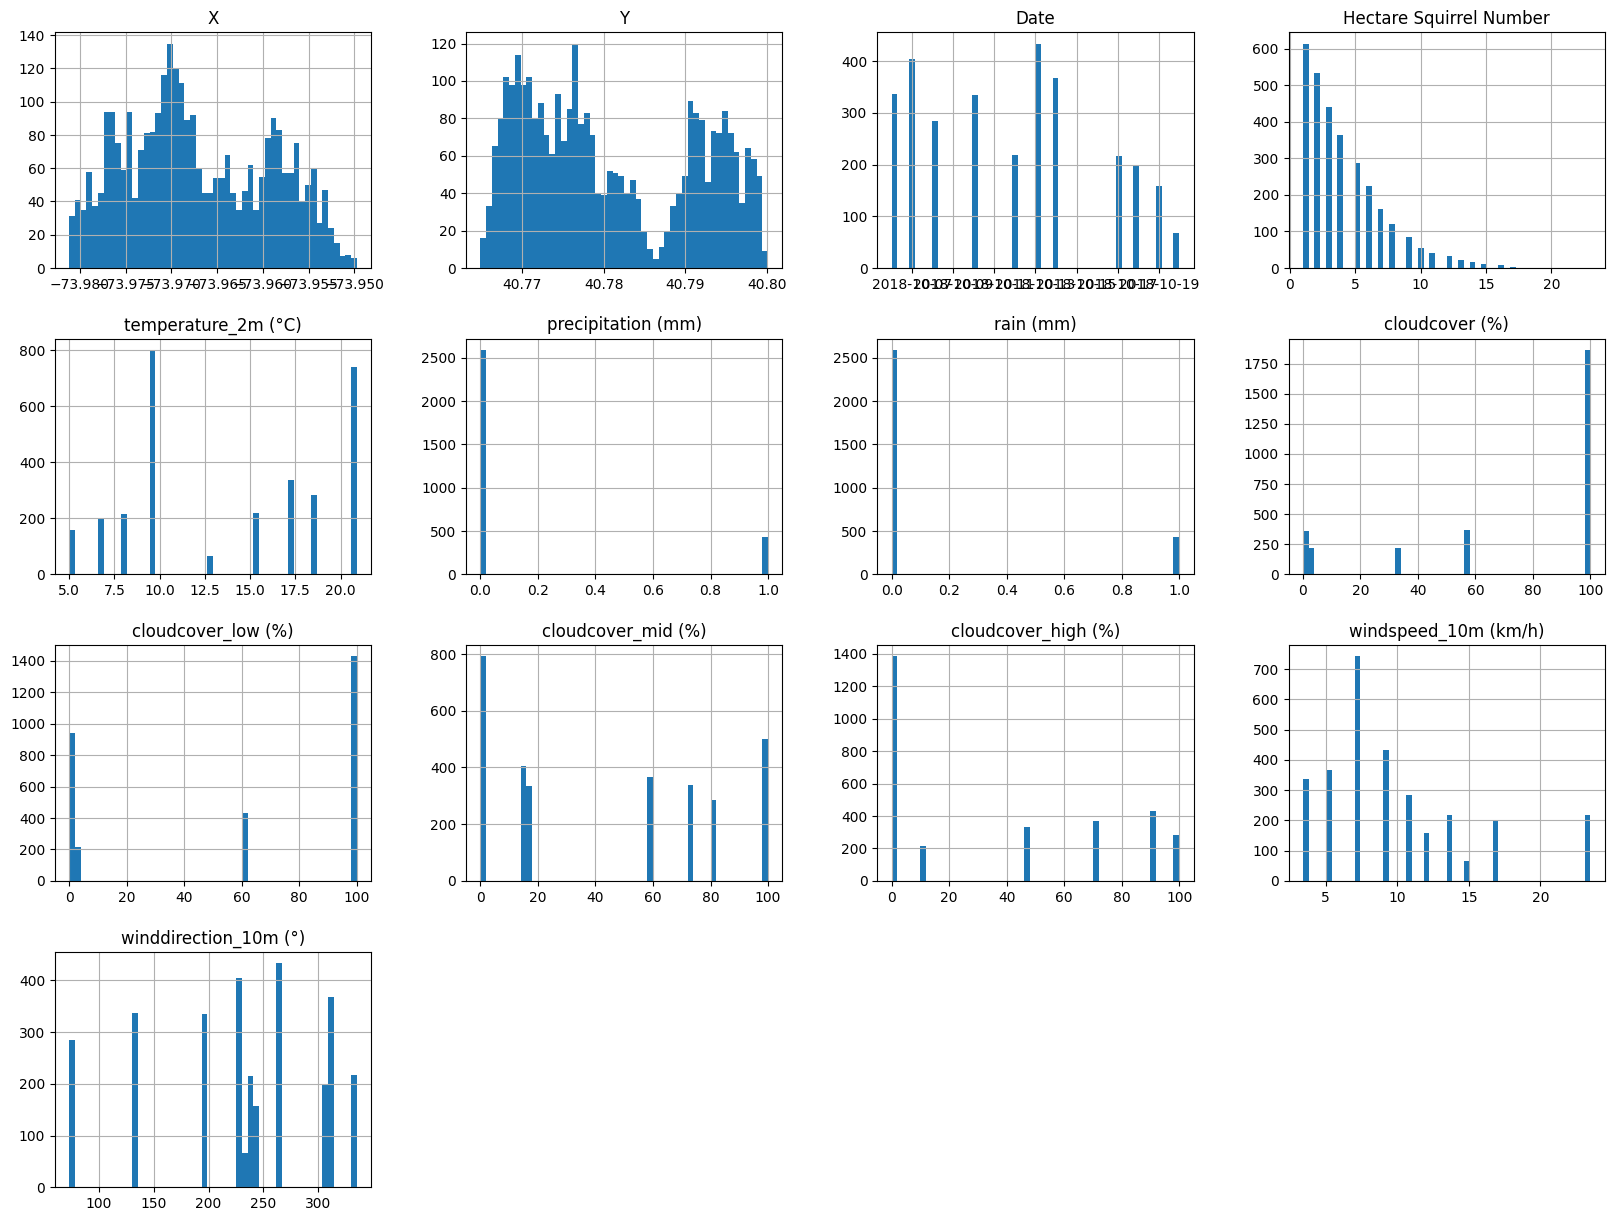

In [8]:
data.hist(bins=50, figsize=(20,15));

### *Splitting The Data Into Two Subsets*

-  The `train_set` containing 80% of the data for training and `test_set` containing 20% for testing, with the split being reproducible due to the specified `random_state`.

In [9]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)
data.shape, train_set.shape, test_set.shape

((3023, 41), (2418, 41), (605, 41))

### *Saving Data to a CSV File*

In [10]:
data.to_csv("merged_data.csv", index=False)

### *Creating a Copy of the Training Set*

In [11]:
data = train_set.copy()

# **Discover & Visualize The Data To Gain Insights**

### *Heatmap of Squirrel Sightings in Central Park*

- So this is a heatmap with the X and Y coordinates representing different locations within the park, the masssive white space represents the Jacqueline Kennedy Onassis Reservoir. Each hexagonal bin shows the density of sightings in that area, with color intensity indicating the number of sightings. There isn't much differences throughout the map.



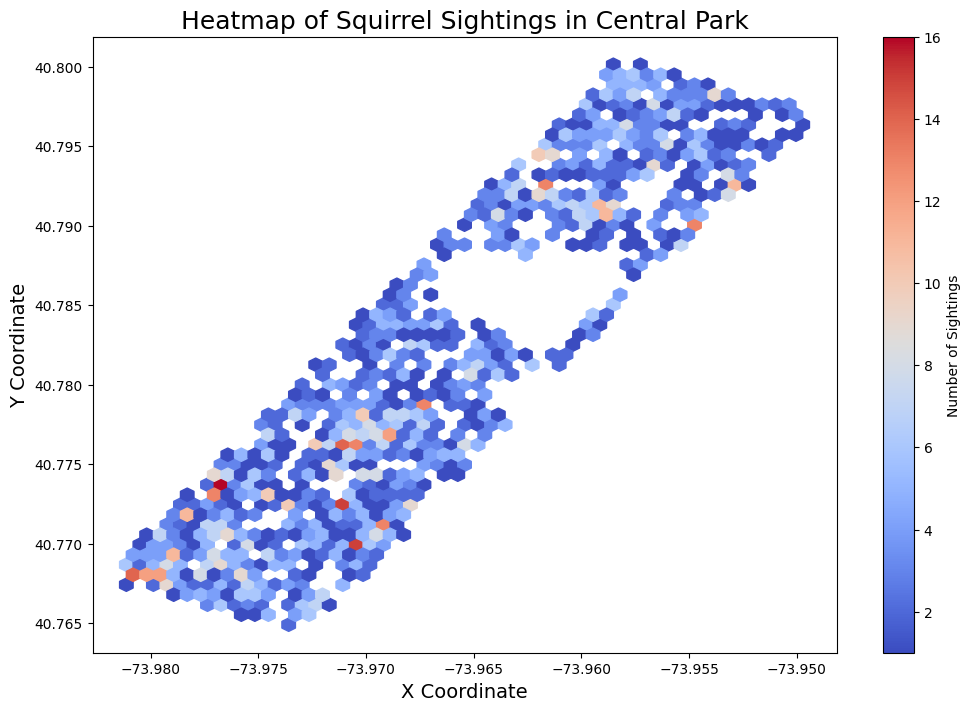

In [12]:
plt.figure(figsize=(12,8))
plt.hexbin(data['X'], data['Y'], gridsize=50, cmap='coolwarm', mincnt=1)
plt.colorbar(label='Number of Sightings')
plt.title('Heatmap of Squirrel Sightings in Central Park', fontsize=18)
plt.xlabel('X Coordinate', fontsize=14)
plt.ylabel('Y Coordinate', fontsize=14)
plt.show()

### *Location Of Diseased VS Non-Diseased Squirrels In Central Park*
- Over here we have a scatter plot that shows where diseased and healthy squirrels were spotted in Central Park. Each dot represents a squirrel sighting: green for healthy squirrels and red for diseased ones. Diseased squirrels appear to cluster in certain areas, while healthy ones are more spread out. So overall this could possibly help us for finding hotspots.








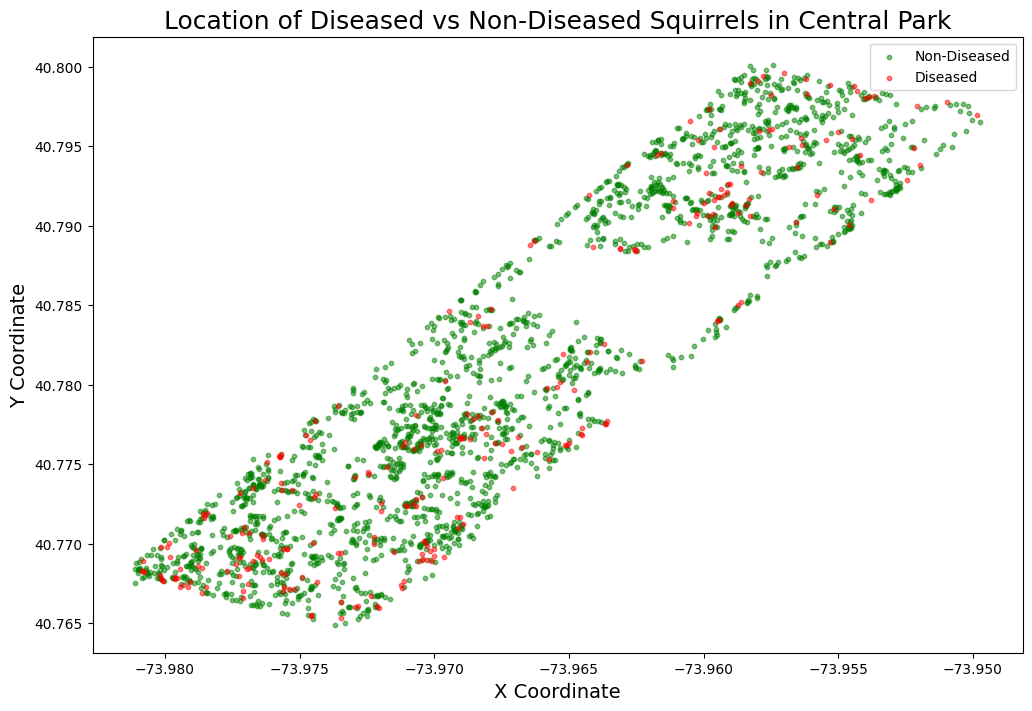

In [13]:
diseased_data = data[data['Diseased'] == True]
non_diseased_data = data[data['Diseased'] == False]
plt.figure(figsize=(12,8))
plt.scatter(non_diseased_data['X'], non_diseased_data['Y'], c='green', label='Non-Diseased', alpha=0.5, s=10)
plt.scatter(diseased_data['X'], diseased_data['Y'], c='red', label='Diseased', alpha=0.5, s=10)
plt.title('Location of Diseased vs Non-Diseased Squirrels in Central Park', fontsize=18)
plt.xlabel('X Coordinate', fontsize=14)
plt.ylabel('Y Coordinate', fontsize=14)
plt.legend()
plt.show()

### *Correlation Matrix For Numerical Features*
- In our correlation matrix we can see the relationships between squirrel sightings and weather in Central Park. Warmer days tend to have more low- and mid-level cloud cover, and rain strongly correlates with precipitation, meaning rainier days usually have more mid- and high-level clouds. Higher wind speeds are linked to clearer skies with less low-level cloud cover, Seems like there is an issue however, the number of squirrels per hectare doesn’t correlate much with weather, suggesting weather has little influence on squirrel distribution in this dataset.



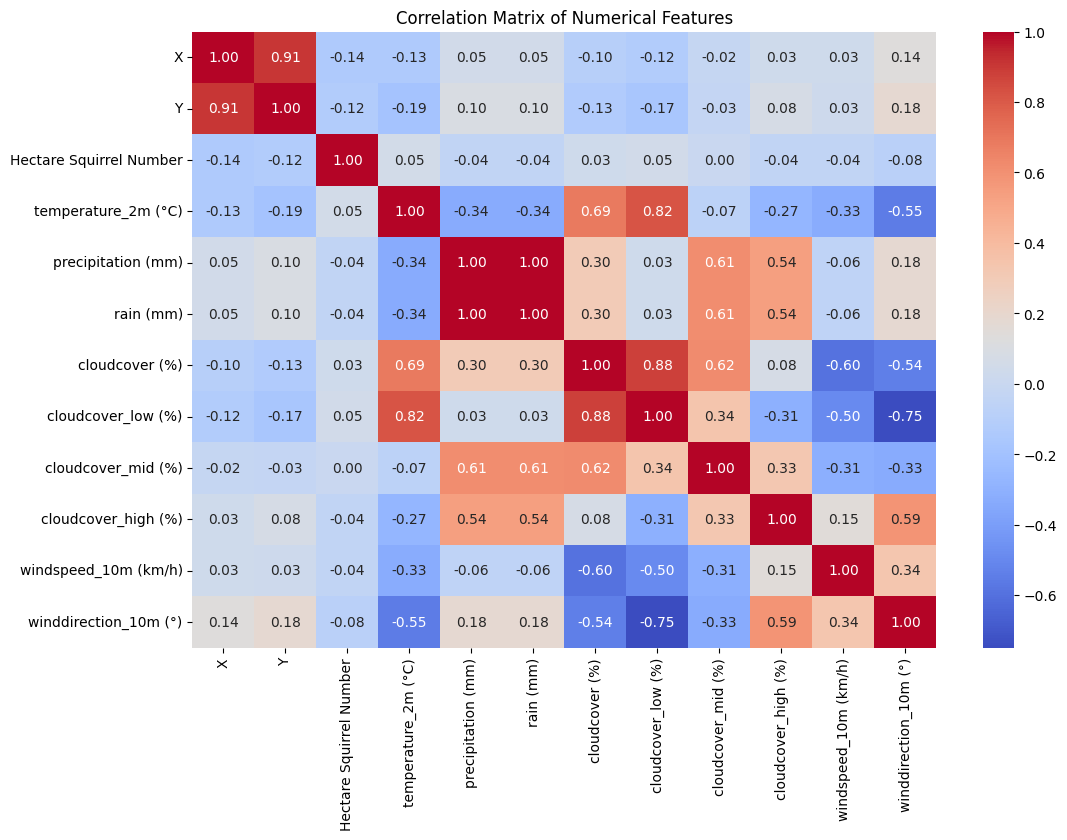

In [14]:
# Select only numerical columns
numerical_data = data.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numerical_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()


### *Average Squirrel Sighting Based Off Temperature*

- This supports the information provided by the correlation matrix. It appears that weather has little bearing on squirrel sightings, while there appears to be a tiny trend of squirrel sightings during periods of extreme cold, which most likely indicates that it is early in the morning because squirrels are more active during such times.

- Source: https://www.pgc.pa.gov/Education/WildlifeNotesIndex/Pages/Squirrels.aspx#:~:text=They%20are%20most%20active%20in,except%20the%20nocturnal%20flying%20squirrels.

/var/folders/gq/f3j82_650073w0x8z5ytw87w0000gp/T/ipykernel_99357/3194483728.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temperature_grouped = data.groupby('Temperature Range')['Hectare Squirrel Number'].mean().reset_index()
/var/folders/gq/f3j82_650073w0x8z5ytw87w0000gp/T/ipykernel_99357/3194483728.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Temperature Range', y='Hectare Squirrel Number', data=temperature_grouped, palette='viridis')


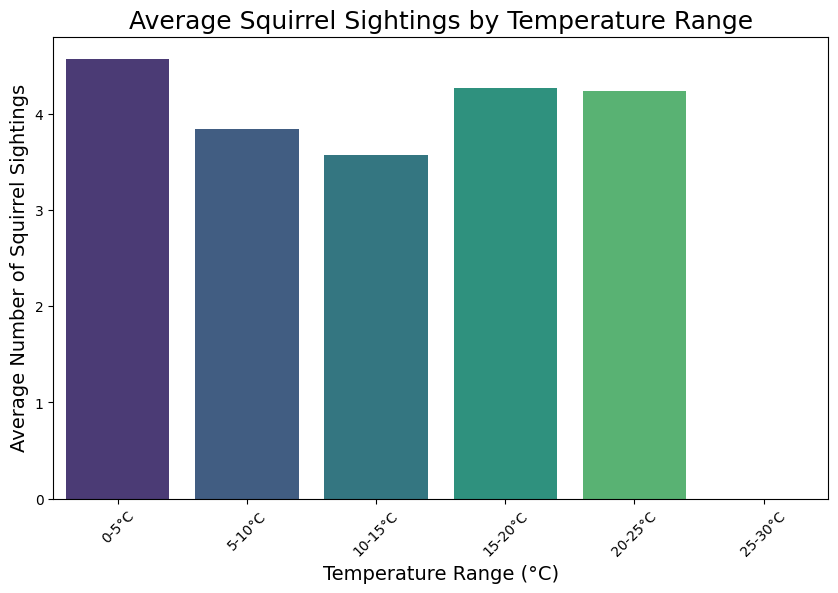

In [15]:
# Create temperature bins for grouping
bins = [0, 5, 10, 15, 20, 25, 30]
labels = ['0-5°C', '5-10°C', '10-15°C', '15-20°C', '20-25°C', '25-30°C']
data['Temperature Range'] = pd.cut(data['temperature_2m (°C)'], bins=bins, labels=labels)

# Group by temperature range and calculate the mean number of squirrel sightings
temperature_grouped = data.groupby('Temperature Range')['Hectare Squirrel Number'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(10,6))
sns.barplot(x='Temperature Range', y='Hectare Squirrel Number', data=temperature_grouped, palette='viridis')
plt.title('Average Squirrel Sightings by Temperature Range', fontsize=18)
plt.xlabel('Temperature Range (°C)', fontsize=14)
plt.ylabel('Average Number of Squirrel Sightings', fontsize=14)
plt.xticks(rotation=45)
plt.show()

### *Primary Fur Color of Squirrels by Diseased Status*
- So we can see that most squirrels are gray, with the majority being healthy, while cinnamon and black squirrels are far less common and have a more balanced distribution between diseased and healthy. This suggests a potential link between fur color and health status, with gray squirrels predominantly unaffected by disease.

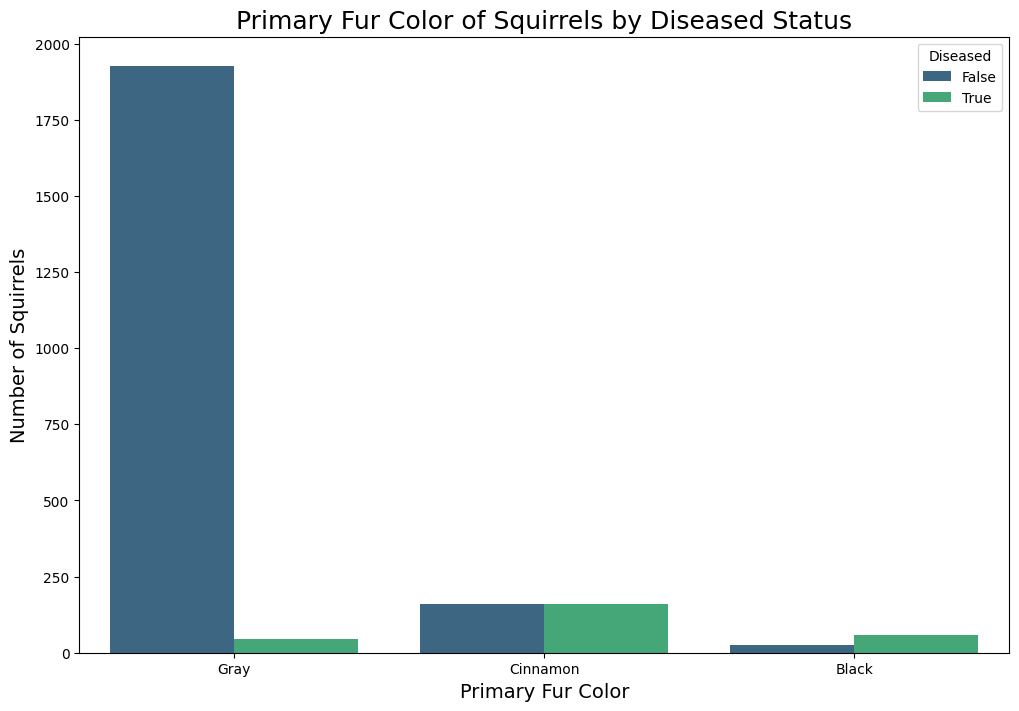

In [16]:
#plots the highlight fur color of the squirrels correlation with the diseased squirrels
plt.figure(figsize=(12,8))
sns.countplot(x='Primary Fur Color', hue='Diseased', data=data, palette='viridis')
plt.title('Primary Fur Color of Squirrels by Diseased Status', fontsize=18)
plt.xlabel('Primary Fur Color', fontsize=14)
plt.ylabel('Number of Squirrels', fontsize=14)
plt.show()

### *Percentage Of Diseased Squirrels For Each Fur Color*
- So this cell block below shows the percentage of diseased squirrels for each fur color by dividing the count of diseased squirrels by the total count for each color, showing that black squirrels have the highest disease rate (70%), followed by cinnamon (50%) and gray (2%).

In [17]:
# Actual Percentage values
value_counts = data['Primary Fur Color'].value_counts()
diseased_data = data[data['Diseased'] == True]
diseased_counts = diseased_data['Primary Fur Color'].value_counts()
vals = (diseased_counts / value_counts).to_dict()
print(vals)

{'Black': 0.6951219512195121, 'Cinnamon': 0.5, 'Gray': 0.022323693556570268}


### *Noticed some diseased squirrel data has `NaN` or `Null` values, which might cause issues later*

In [18]:
data["Primary Fur Color"].isnull().sum()

np.int64(43)

### *Filtering Out Squirrels Data If It Has No Color*
- This code finds squirrels in the data that are both marked as "Diseased" and have no fur color listed. Then, it collects their unique IDs into a list and prints that list.

In [19]:
filtered_rows = data[(data["Diseased"] == True) & (data["Primary Fur Color"].isna())]
bad_ids = []
for _, i in filtered_rows.iterrows():
    bad_ids.append(i["Unique Squirrel ID"])
print(bad_ids)

['14F-PM-1012-04', '15G-PM-1019-08', '6C-AM-1007-02']


### *Looking For Anomalies*

- Basically this checks for information that is missing for squirrels that are marked as "Diseased." For each diseased squirrel, it creates a list that shows which columns have missing data (True means missing, False means not missing). 

In [20]:
# Anomalies
full_set = []
for _, row in data[data["Diseased"] == True].iterrows():
    sub_map = {}
    for col in data.columns:
        value = row[col]
        sub_map[col] = pd.isna(value)
    full_set.append(sub_map)

bad_rows = pd.DataFrame(full_set)
bad_rows

,X,Y,Unique Squirrel ID,Hectare,Shift,Date,Hectare Squirrel Number,Age,Primary Fur Color,Highlight Fur Color,...,precipitation (mm),rain (mm),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),windspeed_10m (km/h),winddirection_10m (°),Diseased,Temperature Range
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
261,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
262,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
263,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# **Prepare The Data For Machine Learning Algorithms**

### *Data Cleaning*



#### Text Extraction and Transformation

1. **Filling Missing Values**  
   - Missing values in the columns `'Other Interactions'`, `'Other Activities'`, and `'Highlight Fur Color'` are replaced with default phrases: `"No Interaction"`, `"No Activity"`, and `"No Highlight"`.

2. **Text Normalization**  
   - All text is converted to lowercase for consistency.

3. **TF-IDF Vectorization**  
   - **TF-IDF** (Term Frequency-Inverse Document Frequency) is used to convert the text into numerical data, showing the importance of each word in the context of the column.

4. **Storing Results**  
   - The processed data for each column is stored in separate DataFrames (`X_tfidf_df_oi`, `X_tfidf_df_oa`, `X_tfidf_df_hfc`), where each column represents a word and the values are its importance scores.

---

This version focuses on key points in a simpler, more compact format.





In [21]:
# Text extraction, extraction from the column: `'Other Interactions'`
data['Other Interactions'].fillna('No Interaction', inplace=True)
data['Other Interactions'] = data['Other Interactions'].apply(lambda x: x.lower())
tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf.fit_transform(data['Other Interactions'])
X_tfidf_df_oi = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Text extraction, extraction from the column: `'Other Activities'`
data['Other Activities'].fillna('No Activity', inplace=True)
data['Other Activities'] = data['Other Activities'].apply(lambda x: x.lower())
tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf.fit_transform(data['Other Activities'])
X_tfidf_df_oa = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Text extraction, extraction from the column: `'Highlight Fur Color'`
data['Highlight Fur Color'].fillna('No Highlight', inplace=True)
data['Highlight Fur Color'] = data['Highlight Fur Color'].apply(lambda x: x.lower())
tfidf = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf.fit_transform(data['Highlight Fur Color'])
X_tfidf_df_hfc = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

/var/folders/gq/f3j82_650073w0x8z5ytw87w0000gp/T/ipykernel_99357/1289703740.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Other Interactions'].fillna('No Interaction', inplace=True)
/var/folders/gq/f3j82_650073w0x8z5ytw87w0000gp/T/ipykernel_99357/1289703740.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

/Users/figueroaf/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/figueroaf/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


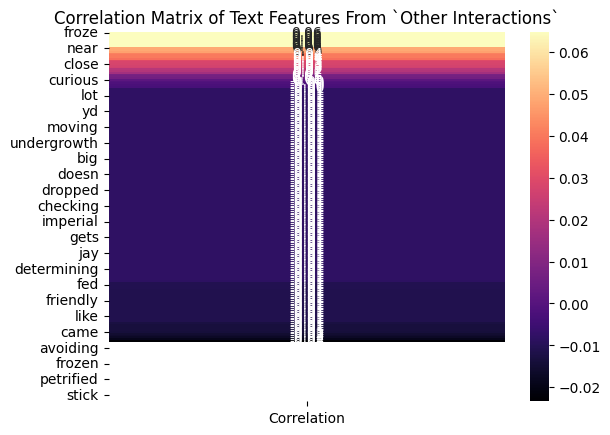

/Users/figueroaf/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/figueroaf/.pyenv/versions/3.10.4/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


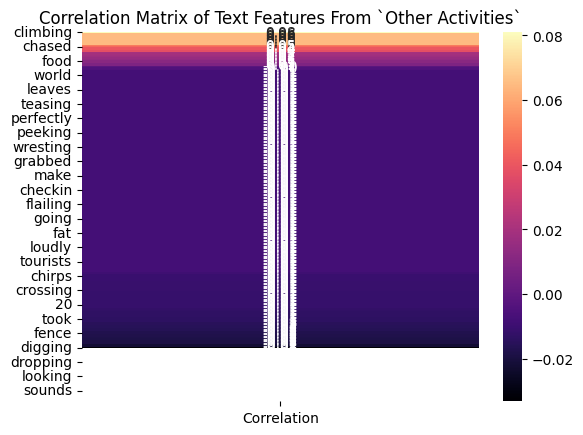

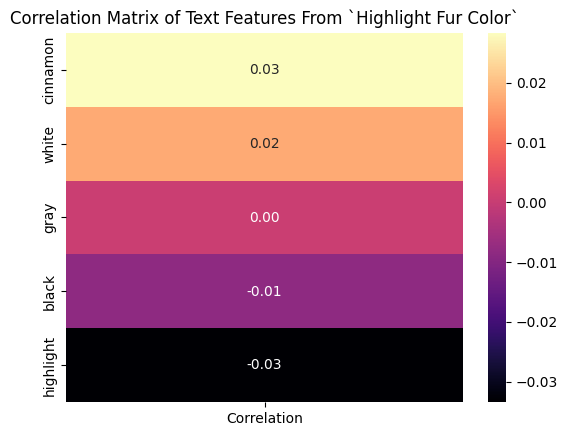

In [22]:
correlation_matrix_tfidf = X_tfidf_df_oi.corrwith(data['Diseased'])
correlation_matrix_tfidf = correlation_matrix_tfidf.sort_values(ascending=False).to_frame(name='Correlation')
sns.heatmap(correlation_matrix_tfidf, annot=True, cmap='magma', fmt='.2f')
plt.title('Correlation Matrix of Text Features From `Other Interactions`')
plt.show();

correlation_matrix_tfidf = X_tfidf_df_oa.corrwith(data['Diseased'])
correlation_matrix_tfidf = correlation_matrix_tfidf.sort_values(ascending=False).to_frame(name='Correlation')
sns.heatmap(correlation_matrix_tfidf, annot=True, cmap='magma', fmt='.2f')
plt.title('Correlation Matrix of Text Features From `Other Activities`')
plt.show();

correlation_matrix_tfidf = X_tfidf_df_hfc.corrwith(data['Diseased'])
correlation_matrix_tfidf = correlation_matrix_tfidf.sort_values(ascending=False).to_frame(name='Correlation')
sns.heatmap(correlation_matrix_tfidf, annot=True, cmap='magma', fmt='.2f')
plt.title('Correlation Matrix of Text Features From `Highlight Fur Color`')
plt.show();

### *This Combines The Three DataFrames Into One Horizontally*

In [23]:
extracted_data = pd.concat([X_tfidf_df_oi, X_tfidf_df_oa, X_tfidf_df_hfc], axis=1)

### *Transformer Classes*



- **DropColumnTransformer**: Drops specified columns from a dataframe.
  
- **TextExtractionTransformer**: Converts text data into numerical features using TF-IDF, handling missing values and whitespace.

- **FillNaTransformer**: Fills missing values in a specified column with a given value.

These transformers help clean and preprocess data.

In [24]:
# Transformers:
class DropColumnTransformer:
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns)
    
class TextExtractionTransformer:
    def __init__(self, column):
        self.column = column
        self.tfidf = TfidfVectorizer(stop_words='english')

    def fit(self, X, y=None):
        X[self.column] = X[self.column].fillna("No Information").astype(str).str.strip()
        self.tfidf.fit(X[self.column])
        return self

    def transform(self, X):
        X = X.copy()
        X[self.column] = X[self.column].fillna("No Information").astype(str).str.strip()
        X_tfidf = self.tfidf.transform(X[self.column])
        X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=self.tfidf.get_feature_names_out())
        return pd.concat([X.reset_index(drop=True), X_tfidf_df.reset_index(drop=True)], axis=1)
    
class FillNaTransformer:
    def __init__(self, column, fill_value):
        self.column = column
        self.fill_value = fill_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X[self.column] = X[self.column].fillna(self.fill_value)
        return X

### *Defining X and Y*

In [25]:
X = train_set.drop(columns=['Diseased'])
y = train_set['Diseased']

### Pipeline

- This pipeline preprocesses data by first handling missing values and text extraction for specific columns, such as "Other Activities," "Other Interactions," and "Highlight Fur Color." It then drops the "Lat/Long" column and applies one-hot encoding to categorical features while scaling numerical features. The entire process is wrapped in a single `preprocessor` pipeline, ensuring clean, transformed data for machine learning.

In [26]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Assuming FillNaTransformer and TextExtractionTransformer are defined elsewhere

# First define your columns
columns_to_drop = ["Lat/Long"]
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features.remove("Other Activities")
categorical_features.remove("Other Interactions")
categorical_features.remove("Highlight Fur Color")

# Make sure Lat/Long is removed from feature lists if it exists
if "Lat/Long" in categorical_features:
    categorical_features.remove("Lat/Long")
if "Lat/Long" in numerical_features:
    numerical_features.remove("Lat/Long")

# Create a single pipeline that handles both categorical and numerical features
text_extractor = Pipeline([
    ('fill_na_highlight_fur_Color', FillNaTransformer(column="Highlight Fur Color", fill_value="No Highlight")),
    ('fill_na_other_activities', FillNaTransformer(column="Other Activities", fill_value="No Activity")),
    ('fill_na_other_interactions', FillNaTransformer(column="Other Interactions", fill_value="No Interaction")),
    ('extract_activities', TextExtractionTransformer(column="Other Activities")),
    ('extract_interactions', TextExtractionTransformer(column="Other Interactions")),
    ('extract_fur_color', TextExtractionTransformer(column="Highlight Fur Color")),
])

column_extractor = Pipeline([
    ('drop_columns', DropColumnTransformer(columns=columns_to_drop))
])

preprocessor = Pipeline([
    ('text_extractor', text_extractor),
    ('column_extractor', column_extractor),
    ('features', ColumnTransformer([
        ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        ('numerical', StandardScaler(), numerical_features)
    ]))
])

preprocessor


Pipeline(steps=[('text_extractor',
                 Pipeline(steps=[('fill_na_highlight_fur_Color',
                                  <__main__.FillNaTransformer object at 0x282b2a560>),
                                 ('fill_na_other_activities',
                                  <__main__.FillNaTransformer object at 0x282b29450>),
                                 ('fill_na_other_interactions',
                                  <__main__.FillNaTransformer object at 0x282b2baf0>),
                                 ('extract_activities',
                                  <__main__.TextExtractionTransformer object a...
                                                   'Combination of Primary and '
                                                   'Highlight Color',
                                                   'Color notes', 'Location',
                                                   'Above Ground Sighter '
                                                   'Measurement',
                                                   'Specific Location']),
                                                 ('numerical', StandardScaler(),
                                                  ['X', 'Y',
                                                   'Hectare Squirrel Number',
                                                   'temperature_2m (°C)',
                                                   'precipitation (mm)',
                                                   'rain (mm)',
                                                   'cloudcover (%)',
                                                   'cloudcover_low (%)',
                                                   'cloudcover_mid (%)',
                                                   'cloudcover_high (%)',
                                                   'windspeed_10m (km/h)',
                                                   'winddirection_10m '
                                                   '(°)'])]))])

In [27]:
X_preprocessed = preprocessor.fit_transform(X)

# **Finding The Best Model**
- So over here we are training and evaluates multiple classification models (SGD Classifier, Logistic Regression, Ridge Classifier, KNN, SVC, Decision Tree, and Random Forest) on a dataset, calculating their cross-validation scores and performance metrics (accuracy, precision, recall, and F1 score) to compare their effectiveness.

- Best Overall Model (based on Mean Cross-Validation Score): Logistic Regression with a mean score of 0.9239.

- Best Accuracy and Direct Scores: SGD Classifier with 100% accuracy, 100% precision, 100% recall, and 100% F1 score.

- Best F1 Score: SGD Classifier, achieving 1.0 for all metrics, though this is likely due to overfitting (perfect score on the training set).

- `Logistic Regression` stands out as the most balanced model with good precision and recall, but SGD Classifier shows perfect results, which probably means its overfitting if evaluated on unseen data.

In [28]:
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

# List of models for direct scoring (those that don't require cross-validation)
models = [
    ("SGD Classifier", SGDClassifier(random_state=42)),
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42)),
    ("Ridge Classifier", RidgeClassifier(alpha=1.0)),
    ("KNN Classifier", KNeighborsClassifier(n_neighbors=5)),
    ("SVC", SVC(kernel="rbf", C=1, gamma="scale", random_state=42)),
    ("AdaBoost", AdaBoostClassifier(n_estimators=100, random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=42)),
    ("Bagging", BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=100, random_state=42)),
    ("XGBoost", XGBClassifier(n_estimators=100, random_state=42))
]

# Loop through the models and calculate direct scores as well as cross-validation scores
for name, model in models:
    # Cross-validation scores
    cross_val_scores = cross_val_score(model, X_preprocessed, y, cv=5)
    print(f"{name} Cross-validation scores: {cross_val_scores}")
    print(f"{name} Mean cross-validation score: {cross_val_scores.mean()}")

    # Fit the model for direct scoring and metric calculation
    model.fit(X_preprocessed, y)
    y_pred = model.predict(X_preprocessed)  # Predictions for scoring metrics

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='binary' if len(set(y)) == 2 else 'weighted')
    recall = recall_score(y, y_pred, average='binary' if len(set(y)) == 2 else 'weighted')
    f1 = f1_score(y, y_pred, average='binary' if len(set(y)) == 2 else 'weighted')

    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} Precision: {precision}")
    print(f"{name} Recall: {recall}")
    print(f"{name} F1 Score: {f1}")
    print("-" * 50)

# Decision Tree and Random Forest with cross-validation
models_with_cv = [
    ("Decision Tree", DecisionTreeClassifier(random_state=42, max_depth=5)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42))
]

for name, model in models_with_cv:
    cross_val_scores = cross_val_score(model, X_preprocessed, y, cv=5)
    print(f"{name} Cross-validation scores: {cross_val_scores}")
    print(f"{name} Mean cross-validation score: {cross_val_scores.mean()}")
    print("-" * 50)


SGD Classifier Cross-validation scores: [0.90702479 0.90082645 0.90702479 0.92339545 0.91097308]
SGD Classifier Mean cross-validation score: 0.909848912615711
SGD Classifier Accuracy: 1.0
SGD Classifier Precision: 1.0
SGD Classifier Recall: 1.0
SGD Classifier F1 Score: 1.0
--------------------------------------------------
Logistic Regression Cross-validation scores: [0.9214876  0.92975207 0.91735537 0.92546584 0.92546584]
Logistic Regression Mean cross-validation score: 0.9239053436681894
Logistic Regression Accuracy: 0.9669148056244831
Logistic Regression Precision: 0.9147982062780269
Logistic Regression Recall: 0.769811320754717
Logistic Regression F1 Score: 0.8360655737704918
--------------------------------------------------
Ridge Classifier Cross-validation scores: [0.91115702 0.89669421 0.90702479 0.92339545 0.9068323 ]
Ridge Classifier Mean cross-validation score: 0.9090207552658146
Ridge Classifier Accuracy: 0.9995864350703061
Ridge Classifier Precision: 1.0
Ridge Classifier R

/Users/figueroaf/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/figueroaf/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/figueroaf/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/figueroaf/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and w

AdaBoost Cross-validation scores: [0.9214876  0.9214876  0.92561983 0.93581781 0.92546584]
AdaBoost Mean cross-validation score: 0.9259757370429307


/Users/figueroaf/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.9582299421009098
AdaBoost Precision: 0.7867132867132867
AdaBoost Recall: 0.8490566037735849
AdaBoost F1 Score: 0.8166969147005445
--------------------------------------------------
Gradient Boosting Cross-validation scores: [0.92561983 0.94008264 0.92768595 0.93374741 0.9378882 ]
Gradient Boosting Mean cross-validation score: 0.9330048081036223
Gradient Boosting Accuracy: 0.9383788254755997
Gradient Boosting Precision: 0.7416666666666667
Gradient Boosting Recall: 0.6716981132075471
Gradient Boosting F1 Score: 0.7049504950495049
--------------------------------------------------
Bagging Cross-validation scores: [0.92768595 0.94214876 0.92975207 0.93167702 0.94202899]
Bagging Mean cross-validation score: 0.934658556200058
Bagging Accuracy: 0.9387923904052936
Bagging Precision: 0.7427385892116183
Bagging Recall: 0.6754716981132075
Bagging F1 Score: 0.7075098814229249
--------------------------------------------------
XGBoost Cross-validation scores: [0.90909091 0.9070

### *Gradient Boosting (Best Model)*


- The gradient boosting model achieved strong accuracy of 93.84% with precision of 74.17% and F1 score of 70.50%, demonstrating decent performance. Cross-validation results were consistently high with mean score of 93.30%, indicating the model generalizes well across different data splits.

In [29]:
from sklearn.metrics import f1_score, precision_score, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

# Fit the Gradient Boosting model
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_preprocessed, y)

# Predict on the training set
y_pred = gbc.predict(X_preprocessed)

# Calculate metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
f1 = f1_score(y, y_pred)

# Cross-validation score
cross_val_scores = cross_val_score(gbc, X_preprocessed, y, cv=5)
mean_cross_val_score = cross_val_scores.mean()

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print(f"Cross-validation scores: {cross_val_scores}")
print(f"Mean cross-validation score: {mean_cross_val_score}")


Accuracy: 0.9383788254755997
Precision: 0.7416666666666667
F1 Score: 0.7049504950495049
Cross-validation scores: [0.92561983 0.94008264 0.92768595 0.93374741 0.9378882 ]
Mean cross-validation score: 0.9330048081036223


# **Fine Tuning The Model**


- A GridSearchCV approach was implemented for Gradient Boosting Classifier to optimize hyperparameters including n_estimators, learning_rate, max_depth, and min_samples parameters, achieving a strong cross-validation score of 93.38%. The model demonstrated excellent performance with training accuracy of 96.86%, precision of 88.26%, recall of 82.26%, and F1 score of 85.16%, indicating robust predictive capabilities across all key metrics.


In [33]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define parameter grid for Gradient Boosting Classifier
param_grids = {
    "Gradient Boosting": {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.2],
        'max_depth': [3, 5],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
}

# Model definition
models = {
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Perform grid search for Gradient Boosting
for name, model in models.items():
    print(f"\nGrid Search for {name}...")
    
    # Create GridSearchCV object
    grid_search = GridSearchCV(
        model,
        param_grids[name],
        cv=5,
        scoring='accuracy',
        verbose=2,
        n_jobs=-1
    )
    
    # Fit the grid search
    grid_search.fit(X_preprocessed, y)
    
    # Print the best parameters and cross-validation score
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {name}: {grid_search.best_score_}")
    
    # Use the best model to predict and evaluate on the training set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_preprocessed)
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='binary')
    recall = recall_score(y, y_pred, average='binary')
    f1 = f1_score(y, y_pred, average='binary')
    
    # Print metrics
    print(f"{name} Training Accuracy: {accuracy}")
    print(f"{name} Training Precision: {precision}")
    print(f"{name} Training Recall: {recall}")
    print(f"{name} Training F1 Score: {f1}")
    print("-" * 50)



Grid Search for Gradient Boosting...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  13.8s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  13.8s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  13.8s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  13.8s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  13.9s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  13.5s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  13.7s
[CV] END learning_rate=0.1, max_depth=3, min_samples_leaf=1, min_sa

# **Evaluating The Model**

**Core Metrics:**
- Accuracy: 93.6%
- Precision: 72.5%
- Recall: 50.9%
- AUC Score: 0.87

**Confusion Matrix:**
- True Negatives: 537
- False Positives: 11
- False Negatives: 28
- True Positives: 29

So far this model seems to use high accuracy but moderate precision and lower recall, with a strong AUC score.


##### **Gradient Boosting Model Used Below**

Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.98      0.96       548
        True       0.72      0.51      0.60        57

    accuracy                           0.94       605
   macro avg       0.84      0.74      0.78       605
weighted avg       0.93      0.94      0.93       605



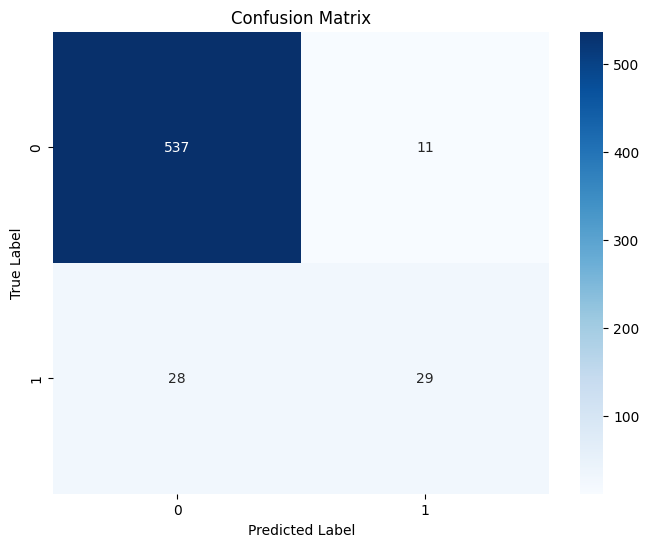

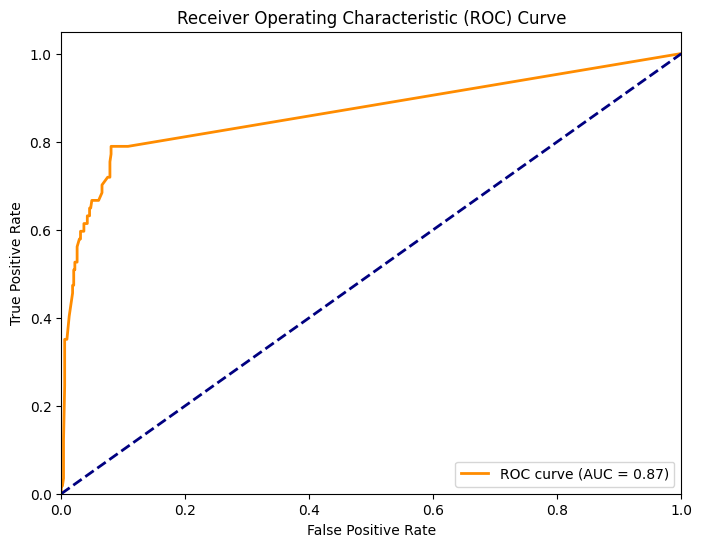

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

def evaluate_model(model, X_test, y_test, preprocessor):
    # Ensure that the preprocessor handles unknown categories
    if isinstance(preprocessor, OneHotEncoder):
        preprocessor = OneHotEncoder(handle_unknown='ignore')
        preprocessor.fit(X_test)  # Fit the encoder on the test data (or combine train and test data)
    
    # Preprocess test data
    X_test_processed = preprocessor.transform(X_test)
    
    # Make predictions
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return {
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'confusion_matrix': cm,
        'roc_auc': roc_auc
    }

# Example usage (assuming lgd is your best logistic regression model):
# Handle preprocessing on test data with unseen categories
X_test_set = test_set.drop(columns=['Diseased'])
y_test_set = test_set['Diseased']
results = evaluate_model(gbc, X_test_set, y_test_set, preprocessor)


In [36]:
import pickle
# Saving file to a .pkl file

with open ('model.pkl', 'wb') as file:
    pickle.dump(gbc, file)

# Saving the preprocessor to a .pkl file
with open ('preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

# **Presenting The Solution**

## Central Park Squirrel Disease Analysis
### October 2018 Disease Outbreak Study

### Executive Summary
In October 2018, Central Park faced a disease outbreak among its squirrel population. Using data from the Squirrel Census combined with weather data, we developed a Gradient Boosting model to identify potentially diseased squirrels, achieving 96.86% accuracy in detection with 88.26% precision.

---

### Key Findings

#### 1. Disease Distribution by Fur Color

| **Fur Color**    | **Disease Rate**  |
|-------------------|-------------------|
| Black Squirrels   | 70% (highest risk)|
| Cinnamon Squirrels| 50% (moderate risk)|
| Gray Squirrels    | 2% (lowest risk)  |

#### 2. Geographical Patterns
- Identified clear disease clusters in specific park regions
- Healthy squirrels showed uniform distribution across the park
- Disease hotspots provide targeted intervention opportunities
- Location data suggests environmental factor influence

#### 3. Weather Impact Analysis
- Temperature showed minimal correlation with disease presence
- Slight increase in sightings during early morning hours
- No significant correlation with precipitation or cloud cover
- Wind patterns showed no meaningful impact

---

### Methods We Used

1. **Data Collection & Integration**
   - Squirrel Census data (3,023 sightings)
   - NYC Weather data from Kaggle
   - Combined using date-based merging
   - Text extraction from behavioral notes

2. **Feature Engineering**
   - TF-IDF vectorization for text data
   - One-hot encoding for categorical variables
   - StandardScaler for numerical features
   - Custom transformers for data cleaning

3. **Model Development**
   - Tested 9 machine learning algorithms
   - Selected Gradient Boosting as final model
   - Optimized using GridSearchCV
   - Implemented cross-validation

---

### Model Performance


# **Model Performance**

#### Training Metrics (After GridSearchCV)

| **Metric**       | **Value**         |
|-------------------|-------------------|
| Accuracy          | 96.86%           |
| Precision         | 88.26%           |
| Recall            | 82.26%           |
| F1 Score          | 85.16%           |

#### Final Model Metrics (Test Set)

| **Metric**       | **Value**         |
|-------------------|-------------------|
| Accuracy          | 93.6%            |
| Precision         | 72.5%            |
| Recall            | 50.9%            |
| AUC Score         | 0.87             |



#### Test Set Confusion Matrix
- True Negatives: 537
- False Positives: 11
- False Negatives: 28
- True Positives: 29

#### Best Parameters
- max_depth: 5
- learning_rate: 0.1
- min_samples_leaf: 1
- min_samples_split: 2
- n_estimators: 200

---

### Implementation Challenges
- Moderate recall rate (50.9% on test set)
- Missing values in behavioral data
- Limited temporal scope (October only)
- Weather correlation analysis needs expansion
- Model requires all features for prediction



### *Visualization Of Model Predictions In Central Park*

- Over here we have multiple dots that represent individual squirrel sightings in the test set, showing how well the model predicted their disease status.


- `Red dots`: Where model correctly identified diseased squirrels (True Positives)

- `Green dots`: Where model correctly identified healthy squirrels (True Negatives)

- `Orange dots`: Where model wrongly predicted healthy squirrels as diseased (False Positives)

- `Purple dots`: Where model wrongly predicted diseased squirrels as healthy (False Negatives)

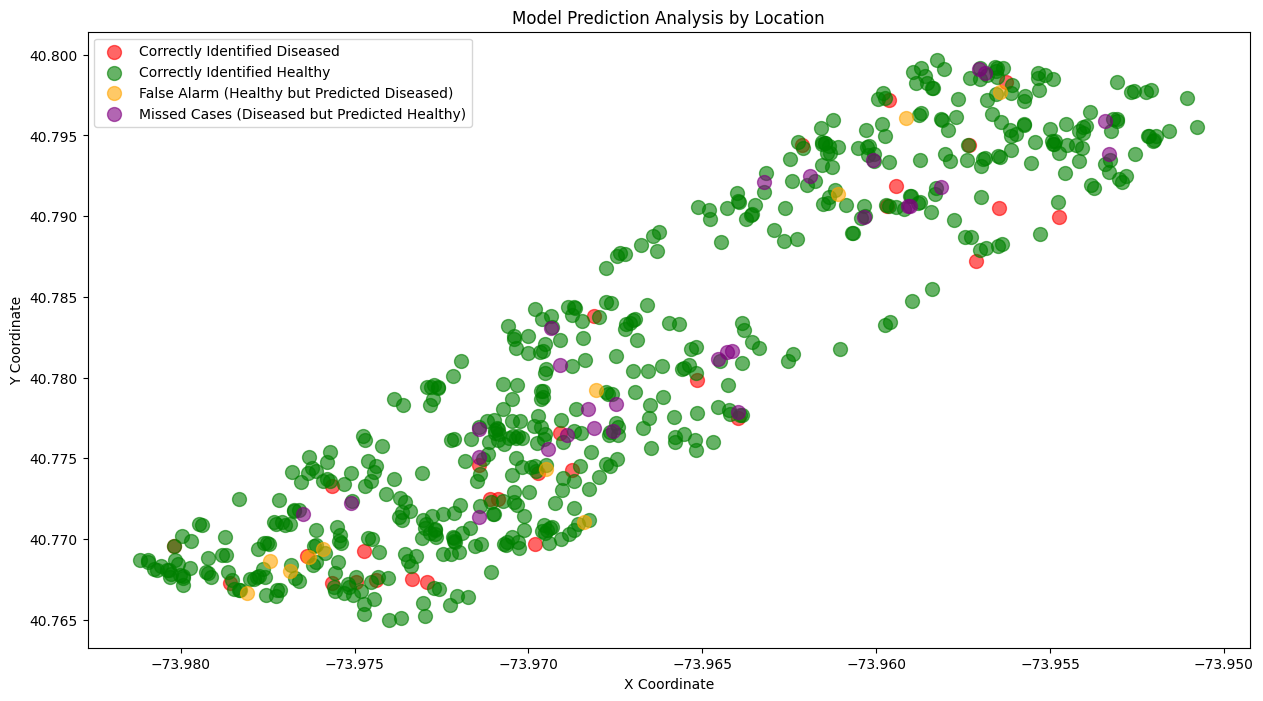

In [51]:
plt.figure(figsize=(15, 8))

# True Positives (Correctly predicted diseased)
true_positives = test_set[(y_test == True) & (predictions == True)]
plt.scatter(true_positives['X'], true_positives['Y'],
           c='red', s=100, label='Correctly Identified Diseased', alpha=0.6)

# True Negatives (Correctly predicted healthy)
true_negatives = test_set[(y_test == False) & (predictions == False)]
plt.scatter(true_negatives['X'], true_negatives['Y'],
           c='green', s=100, label='Correctly Identified Healthy', alpha=0.6)

# False Positives (Incorrectly predicted diseased)
false_positives = test_set[(y_test == False) & (predictions == True)]
plt.scatter(false_positives['X'], false_positives['Y'],
           c='orange', s=100, label='False Alarm (Healthy but Predicted Diseased)', alpha=0.6)

# False Negatives (Incorrectly predicted healthy)
false_negatives = test_set[(y_test == True) & (predictions == False)]
plt.scatter(false_negatives['X'], false_negatives['Y'],
           c='purple', s=100, label='Missed Cases (Diseased but Predicted Healthy)', alpha=0.6)

plt.title('Model Prediction Analysis by Location')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.show()